<a href="https://colab.research.google.com/github/SalimBenchelabi/DL-Seq2Seq/blob/master/Project_DL_on_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAP583 Project: Deep Learning Seq-2-Seq


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# general imports necessary for the notebook
import numpy
import sys
print('All imports done successfully!')

All imports done successfully!


## Machine translation

In this part of the notebook, we will build on the referenced paper on machine translation and run different models to achieve machine translation.

### Data pre-processing

In [ ]:
# dataload.py

import math
import re
import os
import numpy as np
import torch
import random
import warnings
from io import open
import unicodedata
import matplotlib.pyplot as plt
from torch.autograd import Variable
import time

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = (8, 8)
np.random.seed(42)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

use_cuda = torch.cuda.is_available()

import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/MAP583/neural_machine_translation/data.zip', 'r')
zip_ref.extractall()
zip_ref.close()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs
  

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p,reverse):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[reverse].startswith(eng_prefixes)


def filterPairs(pairs, reverse):
    if reverse:
        reverse = 1
    else:
        reverse = 0
    return [pair for pair in pairs if filterPair(pair,reverse)]
  

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs,reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

  
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
#     print('var =', var)
    if use_cuda: var = var.cuda()
    return var


def variables_from_pair(pair, input_lang, output_lang):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)
  
    
def save_checkpoint(epoch, model, optimizer, directory, \
                    filename='best.pt'):
    checkpoint=({'epoch': epoch+1,
    'model': model.state_dict(),
    'optimizer' : optimizer.state_dict()
    })
    try:
        torch.save(checkpoint, os.path.join(directory, filename))
        
    except:
        os.mkdir(directory)
        torch.save(checkpoint, os.path.join(directory, filename))  

In [ ]:
# model.py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, bi_dir=True):
        super(EncoderRNN, self).__init__()
        if bi_dir == True:
            self.bi = 2
        else:
            self.bi = 1
        self.hidden_size = hidden_size
        self.n_layers=n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=False, bidirectional = bi_dir)

    def forward(self, input, hidden):
        seq_len = len(input)
        embedded = self.embedding(input).view(seq_len, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.n_layers*self.bi, 1, self.hidden_size, device=device)
    

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, attn_type = 'gen', n_layers=1, dropout_p=0.1, bi_dir=True):
        super(AttnDecoderRNN, self).__init__()
        if bi_dir == True:
            self.bi = 2
        else:
            self.bi = 1
        self.hidden_size = hidden_size
        self.maxlen = 0
        self.attn_type = attn_type

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,  dropout=dropout_p, 
                          batch_first=False, bidirectional = bi_dir)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()        
        self.wd = nn.Linear(hidden_size*2*self.bi, hidden_size)
        self.ws = nn.Linear(hidden_size*self.bi, hidden_size*self.bi)
        self.out2 = nn.Linear(hidden_size*2, output_size)
        
    def score(self, dec_st, enc_st):
        if self.attn_type == 'dot':
            return torch.mm(dec_st, enc_st.t())
        elif self.attn_type == 'gen':
            return torch.mm(self.ws(enc_st), dec_st.t())
        
    def align(self, dec_state, enc_states):  
        alpha = self.score(dec_state, enc_states)
        alpha = torch.softmax(alpha.t(), dim=1)
        return torch.mm(alpha, enc_states), alpha
        
    def forward(self, input, hidden, encoder_input):
        
        output = self.embedding(input).view(1,1,-1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        dec_out = output[0]
        c_t, attn_wt = self.align(dec_out, encoder_input)
        h_t = F.tanh(self.wd(torch.cat((c_t,dec_out),dim=1)))
        out_word = self.softmax(self.out(h_t))
        return out_word, hidden, attn_wt

### Running the base model

Here, we run the base model presented in the paper and provided in the Git repository. As we are working on colab, we can afford to train the model from sracth and eventually compare the accuracy to a pre-trained model.

In [ ]:
# training the model from scratch

# hyperparameters
hidden_size = 500
epochs = 50000
print_every = 10000
n_layers = 2
dropout_p = 0.05
learning_rate = 0.0001

print_loss = 0
total_loss = torch.Tensor([0]).cuda()
print_loss_total = 0
start = time.time()
teacher_forcing_ratio = 0.5  # 50% teacher forcing and 50% scheduled sampling
clip = 5.0
max_length = 10
fra_to_eng = True
attn_score = 'gen' # can be - 'gen', 'concat', 'dot'

input_lang, output_lang, pairs = prepareData('eng', 'fra', fra_to_eng)
print(random.choice(pairs))

training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang) for i in range(epochs)]

encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

for i in range(1,epochs):
  
  encoder_hidden = encoder.initHidden()
  
  training_pair = training_pairs[i - 1]
  input_tensor = training_pair[0]
  target_tensor = training_pair[1] 
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  loss = 0
  
  encoder_outputs, hidden = encoder( input_tensor, encoder_hidden)
  
  encoder_outputs = encoder_outputs.squeeze(1)
  decoder_input = torch.tensor([[SOS_token]], device=device)
  decoder_attentions = torch.zeros(max_length, max_length)
  decoder_attentions = []
  

  use_teacher_forcing = random.random() < teacher_forcing_ratio

  if use_teacher_forcing:
    for word in range(target_tensor.size()[0]):
      decoder_output, hidden, decoder_attention = decoder(decoder_input, hidden, encoder_outputs)
      loss += criterion(decoder_output, target_tensor[word])
      decoder_input = target_tensor[word]
      decoder_attentions.append(decoder_attention)
  else:
    for di in range(target_tensor.size()[0]):
      decoder_output, hidden, decoder_attention = decoder(decoder_input, hidden, encoder_outputs)      
      topv, topi = decoder_output.data.topk(1)
      ni = topi[0][0]
      if ni == EOS_token:
          break
      decoder_input = Variable(torch.cuda.LongTensor([[ni]]))      
      decoder_attentions.append(decoder_attention)
      loss += criterion(decoder_output, target_tensor[di])
  
  loss.backward()
  
  torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
  torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

  encoder_optimizer.step()
  decoder_optimizer.step()
  
  print_loss_total += loss.item()/target_tensor.size()[0]
  
  if i % print_every == 0:
    print_loss_avg = print_loss_total / print_every
    print_loss_total = 0
    print('%s (%d %d%%) %.4f' % (timeSince(start, i / epochs),
                                         i, i / epochs * 100, print_loss_avg))
    print (decoder_attention)
    
  print_loss+=1
  
if fra_to_eng:
    save_checkpoint(epochs, encoder, encoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng', \
                        filename='encoder.pt')
    save_checkpoint(epochs, decoder, decoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng', \
                        filename='decoder.pt')
else:
    save_checkpoint(epochs, encoder, encoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra', \
                        filename='encoder.pt')
    save_checkpoint(epochs, decoder, decoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra', \
                        filename='decoder.pt')

### Making some inference

In [ ]:
# eval_nmt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import torch

def load_pre_trained(lang):
    ####################################################
    # default parameters, do not change
    fra_to_eng = False
    hidden_size = 500
    n_layers = 2
    dropout_p = 0.05
    attn_score = 'gen'
    ####################################################
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if lang == 'eng-fra':
        input_lang, output_lang, pairs = prepareData('eng', 'fra', fra_to_eng)
        encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
        decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
        encoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra/encoder.pt')['model'])
        decoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra/decoder.pt')['model'])
    else:
        input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
        encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
        decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
        encoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng/encoder.pt')['model'])
        decoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng/decoder.pt')['model'])

    return encoder, decoder

def evaluate(sentence, encoder, decoder, input_lang,output_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs, encoder_hidden = encoder( input_tensor, encoder_hidden)
        encoder_outputs = encoder_outputs.squeeze(1)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_attentions[di] = decoder_attention.data
            #print (decoder_attention.shape[1])
            decoder_attentions[di,:decoder_attention.shape[1]] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions
    
def viz_attn(input_sentence, output_words, attentions):
    maxi = max(len(input_sentence.split()),len(output_words))
    attentions = attentions[:maxi,:maxi]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap=cm.bone)
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    
def evalRand(n=1):
    for i in range(n):
        pair = random.choice(pairs)
        print('French Text -->', pair[0])
        print('Ground Truth ->', pair[1])
        output_words, attn = evaluate(pair[0])
        output_sentence = ' '.join(output_words)
        print('English o/p -->', output_sentence)
        print('')
        maxi = max(len(pair[0].split()),len(output_words))
        
def evalText(inp, encoder, decoder, inp_lang = 'English', out_lang = 'French'):
    print('%s Text -->'%inp_lang, inp)
    if  inp_lang == 'English':
      input_lang, output_lang , _ = prepareData('eng', 'fra', False)
    else :
      input_lang, output_lang , _ = prepareData('eng', 'fra', True)

    output_words, attn = evaluate(inp, encoder, decoder,input_lang,output_lang)
    output_sentence = ' '.join(output_words)
    print('%s o/p -->'%out_lang, output_sentence)
    print('')
    return inp, output_words, attn

In [ ]:
# loading the pre-trained models
encoder_e2f, decoder_e2f = load_pre_trained('eng-fra') # 'eng-fra' or 'fra-eng'
encoder_f2e, decoder_f2e = load_pre_trained('fra-eng') # 'eng-fra' or 'fra-eng'

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
eng 2925
fra 4489
Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925


English Text --> we are the best .
Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
eng 2925
fra 4489
French o/p --> nous sommes les meilleurs . <EOS>

French Text --> on joue au rugby .
Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
English o/p --> we re playing there . <EOS>



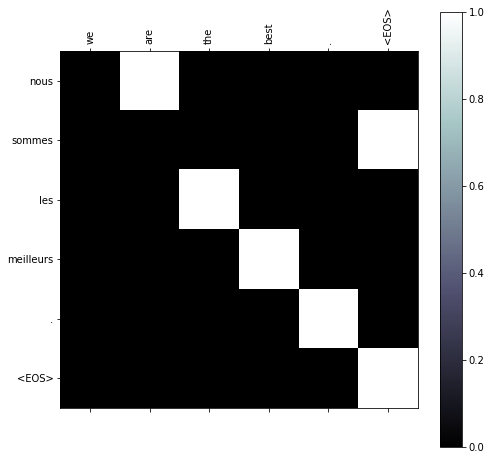

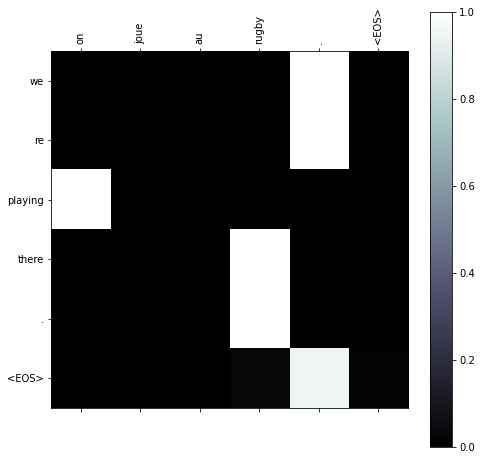

In [ ]:
eng_text = "we are the best ."
fra_text = "on joue au rugby ."
inp1, out1, attn1 = evalText(eng_text, encoder_e2f, decoder_e2f)
#English Text - "i m not giving you any money ."
#French o/p   - "je ne te donnerai pas argent . <EOS>"

inp2, out2, attn2 = evalText(fra_text, encoder_f2e, decoder_f2e, inp_lang='French', out_lang='English')
#French Text  - "je crains de vous avoir offense ."
#English o/p  - "i m afraid i ve offended you . <EOS>"

viz_attn(inp1 ,out1 ,attn1)
viz_attn(inp2 ,out2 ,attn2)

## BLEU tests

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)


1.0


In [ ]:
evalText("she is strong .", encoder_e2f, decoder_e2f)

English Text --> she is strong .
French o/p --> elle est forte . <EOS>



('she is strong .',
 ['elle', 'est', 'forte', '.', '<EOS>'],
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.9980, 0.0020, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000],
         [0.0000, 0.0000, 0.00

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', False)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
eng 2925
fra 4489


In [ ]:
eng_sent= []
fr_trad =[]

length = len(pairs)//1

for p in pairs[:length]:
  eng_sent.append(p[0])
  fr_trad.append([p[1].split()])


In [ ]:
fr_cand = []
for sentence in eng_sent:
    _,out,_ = evalText(sentence, encoder_e2f, decoder_e2f)
    fr_cand.append(out[:len(out)-1]) #enlever <EOS>



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
French o/p --> je te vois le un un nouveau . <EOS>

English Text --> i m sick and tired of reading .
French o/p --> j en ai assez de lire . <EOS>

English Text --> i m sick and tired of reading .
French o/p --> j en ai assez de lire . <EOS>

English Text --> i m so happy that you re here .
French o/p --> je suis tellement heureux que vous soyez la . <EOS>

English Text --> i m sorry i misunderstood you .
French o/p --> je suis desole de t avoir blessee . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je t ai effraye . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je t ai effraye . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je t ai effraye . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je t ai effraye . <EOS>

English Text --> i m sorry i

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
score = corpus_bleu(fr_trad, fr_cand)
print(score)



0.4639462964066017


In [ ]:
from torchtext.data.metrics import bleu_score
score = bleu_score(fr_cand,fr_trad)
print(score)


0.46431538831503577


## Comparaison en changeant la fonction de score

### Entrainement des 2 modèles

In [ ]:
# # training the model from scratch

# # hyperparameters
# hidden_size = 500
# epochs = 50000
# print_every = 1000
# n_layers = 2
# dropout_p = 0.05
# learning_rate = 0.0001

# print_loss = 0
# total_loss = torch.Tensor([0]).cuda()
# print_loss_total = 0
# start = time.time()
# teacher_forcing_ratio = 0.5  # 50% teacher forcing and 50% scheduled sampling
# clip = 5.0
# max_length = 10
# fra_to_eng = False
# attn_score = 'gen' # can be - 'gen', 'concat', 'dot'

# input_lang, output_lang, pairs = prepareData('eng', 'fra', fra_to_eng)
# print(random.choice(pairs))

# training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang) for i in range(epochs)]

# encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
# decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
# encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
# criterion = nn.NLLLoss()

# loss_gen = []

# for i in range(1,epochs):
  
#   encoder_hidden = encoder.initHidden()
  
#   training_pair = training_pairs[i - 1]
#   input_tensor = training_pair[0]
#   target_tensor = training_pair[1] 
#   encoder_optimizer.zero_grad()
#   decoder_optimizer.zero_grad()
#   loss = 0.0
  
#   encoder_outputs, hidden = encoder( input_tensor, encoder_hidden)
  
#   encoder_outputs = encoder_outputs.squeeze(1)
#   decoder_input = torch.tensor([[SOS_token]], device=device)
#   decoder_attentions = torch.zeros(max_length, max_length)
#   decoder_attentions = []
  

#   use_teacher_forcing = random.random() < teacher_forcing_ratio

#   if use_teacher_forcing:
#     for word in range(target_tensor.size()[0]):
#       decoder_output, hidden, decoder_attention = decoder(decoder_input, hidden, encoder_outputs)
#       loss += criterion(decoder_output, target_tensor[word])
#       decoder_input = target_tensor[word]
#       decoder_attentions.append(decoder_attention)
#   else:
#     for di in range(target_tensor.size()[0]):
#       decoder_output, hidden, decoder_attention = decoder(decoder_input, hidden, encoder_outputs)      
#       topv, topi = decoder_output.data.topk(1)
#       ni = topi[0][0]
#       if ni == EOS_token:
#           break
#       decoder_input = Variable(torch.cuda.LongTensor([[ni]]))      
#       decoder_attentions.append(decoder_attention)
#       loss += criterion(decoder_output, target_tensor[di])
  
#   loss.backward()
  
#   torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
#   torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

#   encoder_optimizer.step()
#   decoder_optimizer.step()
  
#   print_loss_total += loss.item()/target_tensor.size()[0]
  
  

#   if i % print_every == 0:
#     print_loss_avg = print_loss_total / print_every
#     print_loss_total = 0
#     print('%s (%d %d%%) %.4f' % (timeSince(start, i / epochs),
#                                          i, i / epochs * 100, print_loss_avg))
#     print (decoder_attention)
#     loss_gen.append(print_loss_avg)
    
#   print_loss+=1
  
# if fra_to_eng:
#     save_checkpoint(epochs, encoder, encoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_gen', \
#                         filename='encoder.pt')
#     save_checkpoint(epochs, decoder, decoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_gen', \
#                         filename='decoder.pt')
# else:
#     save_checkpoint(epochs, encoder, encoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_gen', \
#                         filename='encoder.pt')
#     save_checkpoint(epochs, decoder, decoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_gen', \
#                         filename='decoder.pt')

In [ ]:
# # training the model from scratch

# # hyperparameters
# hidden_size = 500
# epochs = 50000
# print_every = 1000
# n_layers = 2
# dropout_p = 0.05
# learning_rate = 0.0001

# print_loss = 0
# total_loss = torch.Tensor([0]).cuda()
# print_loss_total = 0
# start = time.time()
# teacher_forcing_ratio = 0.5  # 50% teacher forcing and 50% scheduled sampling
# clip = 5.0
# max_length = 10
# fra_to_eng = False
# attn_score = 'dot' # can be - 'gen', 'concat', 'dot'

# input_lang, output_lang, pairs = prepareData('eng', 'fra', fra_to_eng)
# print(random.choice(pairs))

# training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang) for i in range(epochs)]

# encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
# decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
# encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
# decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
# criterion = nn.NLLLoss()

# loss_dot = []

# for i in range(1,epochs):
  
#   encoder_hidden = encoder.initHidden()
  
#   training_pair = training_pairs[i - 1]
#   input_tensor = training_pair[0]
#   target_tensor = training_pair[1] 
#   encoder_optimizer.zero_grad()
#   decoder_optimizer.zero_grad()
#   loss = 0
  
#   encoder_outputs, hidden = encoder( input_tensor, encoder_hidden)
  
#   encoder_outputs = encoder_outputs.squeeze(1)
#   decoder_input = torch.tensor([[SOS_token]], device=device)
#   decoder_attentions = torch.zeros(max_length, max_length)
#   decoder_attentions = []
  

#   use_teacher_forcing = random.random() < teacher_forcing_ratio

#   if use_teacher_forcing:
#     for word in range(target_tensor.size()[0]):
#       decoder_output, hidden, decoder_attention = decoder(decoder_input, hidden, encoder_outputs)
#       loss += criterion(decoder_output, target_tensor[word])
#       decoder_input = target_tensor[word]
#       decoder_attentions.append(decoder_attention)
#   else:
#     for di in range(target_tensor.size()[0]):
#       decoder_output, hidden, decoder_attention = decoder(decoder_input, hidden, encoder_outputs)      
#       topv, topi = decoder_output.data.topk(1)
#       ni = topi[0][0]
#       if ni == EOS_token:
#           break
#       decoder_input = Variable(torch.cuda.LongTensor([[ni]]))      
#       decoder_attentions.append(decoder_attention)
#       loss += criterion(decoder_output, target_tensor[di])
  
#   loss.backward()
  
#   torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
#   torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)

#   encoder_optimizer.step()
#   decoder_optimizer.step()
  
#   print_loss_total += loss.item()/target_tensor.size()[0]
  

#   if i % print_every == 0:
#     print_loss_avg = print_loss_total / print_every
#     print_loss_total = 0
#     print('%s (%d %d%%) %.4f' % (timeSince(start, i / epochs),
#                                          i, i / epochs * 100, print_loss_avg))
#     print (decoder_attention)
#     loss_dot.append(print_loss_avg)
#   print_loss+=1
  
# if fra_to_eng:
#     save_checkpoint(epochs, encoder, encoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_dot', \
#                         filename='encoder.pt')
#     save_checkpoint(epochs, decoder, decoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_dot', \
#                         filename='decoder.pt')
# else:
#     save_checkpoint(epochs, encoder, encoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_dot', \
#                         filename='encoder.pt')
#     save_checkpoint(epochs, decoder, decoder_optimizer, '/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_dot', \
#                         filename='decoder.pt')

In [ ]:
# import pandas as pd
# df = pd.DataFrame(loss_dot)
# df.to_csv('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/loss_dot.csv')

In [ ]:
# import pandas as pd
# df = pd.DataFrame(loss_gen)
# df.to_csv('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/loss_gen.csv')

In [ ]:
import pandas as pd
loss_gen = pd.read_csv('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/loss_gen.csv')
loss_dot = pd.read_csv('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/loss_dot.csv')



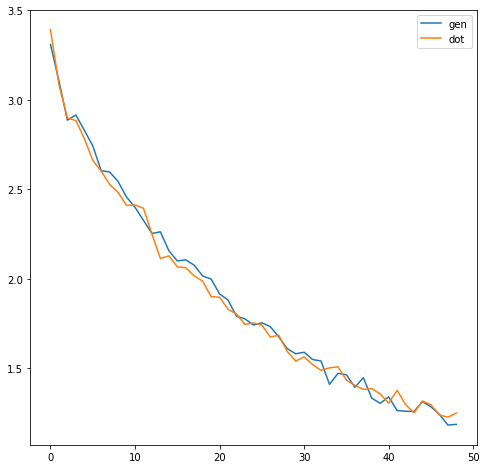

In [ ]:
b1 = plt.plot(loss_gen['0'],label = 'gen')
b2 = plt.plot(loss_dot['0'],label = 'dot')
plt.legend(loc = 'upper_right')
plt.show()

### Comparaison du calcul des BLEU

In [ ]:
def load_pre_trained(lang):
    ####################################################
    # default parameters, do not change
    fra_to_eng = False
    hidden_size = 500
    n_layers = 2
    dropout_p = 0.05
    attn_score = 'gen'
    ####################################################
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if lang == 'eng-fra':
        input_lang, output_lang = eng_lang, fr_lang
        encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
        decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
        encoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_gen/encoder.pt')['model'])
        decoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_gen/decoder.pt')['model'])
    else:
        input_lang, output_lang  = fr_lang, eng_lang
        encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
        decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
        encoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_gen/encoder.pt')['model'])
        decoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_gen/decoder.pt')['model'])

    return encoder, decoder


In [ ]:
#BLEU for gen score

input_lang, output_lang, pairs = prepareData('eng', 'fra', False)
eng_sent= []
fr_trad =[]

encoder,decoder = load_pre_trained('eng-fra')

length = len(pairs)//1

for p in pairs[:length]:
  eng_sent.append(p[0])
  fr_trad.append([p[1].split()])

fr_cand = []
for sentence in eng_sent:
    _,out,_ = evalText(sentence, encoder, decoder)
    fr_cand.append(out[:len(out)-1]) #enlever <EOS>

from torchtext.data.metrics import bleu_score
score_gen = bleu_score(fr_cand,fr_trad)
print('Bleu for gen-score : ', score_gen )


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

English Text --> i m sick and tired of reading .
French o/p --> je suis fatigue de lire . <EOS>

English Text --> i m sick and tired of reading .
French o/p --> je suis fatigue de lire . <EOS>

English Text --> i m so happy that you re here .
French o/p --> je suis heureuse que vous vous la la . <EOS>

English Text --> i m sorry i misunderstood you .
French o/p --> je suis desole de vous avoir crie . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je vous ai effraye . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je vous ai effraye . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je vous ai effraye . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis desole si je vous ai effraye . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je sui

In [ ]:
def load_pre_trained(lang):
    ####################################################
    # default parameters, do not change
    fra_to_eng = False
    hidden_size = 500
    n_layers = 2
    dropout_p = 0.05
    attn_score = 'gen'
    ####################################################
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if lang == 'eng-fra':
        input_lang, output_lang = eng_lang, fr_lang
        encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
        decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
        encoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_dot/encoder.pt')['model'])
        decoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/eng-fra_dot/decoder.pt')['model'])
    else:
        input_lang, output_lang  = fr_lang, eng_lang
        encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
        decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, attn_score, n_layers, dropout_p).to(device)
        encoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_dot/encoder.pt')['model'])
        decoder.load_state_dict(torch.load('/content/drive/MyDrive/MAP583/neural_machine_translation/saved_model/fra-eng_dot/decoder.pt')['model'])

    return encoder, decoder


In [ ]:
#BLEU for dot score

input_lang, output_lang, pairs = prepareData('eng', 'fra', False)
eng_sent= []
fr_trad =[]

encoder,decoder = load_pre_trained('eng-fra')

# Generating the reference and the candidate
length = len(pairs)//1

for p in pairs[:length]:
  eng_sent.append(p[0])
  fr_trad.append([p[1].split()])

fr_cand = []
for sentence in eng_sent:
    _,out,_ = evalText(sentence, encoder, decoder)
    fr_cand.append(out[:len(out)-1]) #enlever <EOS>


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.

English Text --> i m sick and tired of reading .
French o/p --> je suis en train de <EOS>

English Text --> i m sick and tired of reading .
French o/p --> je suis en train de <EOS>

English Text --> i m so happy that you re here .
French o/p --> je suis si que ici la la . <EOS>

English Text --> i m sorry i misunderstood you .
French o/p --> je suis desole de je fait . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> desole desole je suis si je je suis <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> desole desole je suis si je vous ai . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> desole desole je suis si je je suis . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> desole desole je suis si je vous ai . <EOS>

English Text --> i m sorry if i frightened you .
French o/p --> je suis si si je suis si . <EOS>

English Te

In [ ]:
print('Bleu for gen-score : ', score_gen )
print('Bleu for dot-score : ', score_dot )

Bleu for gen-score :  0.47767702390298994
Bleu for dot-score :  0.22917193991817


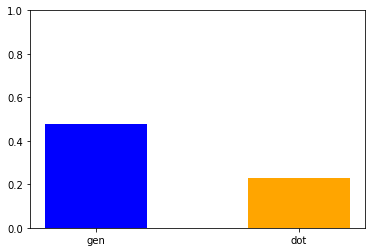

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['gen','dot'],[score_gen,score_dot], color = ['blue','orange'], width = 0.5)
plt.ylim([0,1])
plt.show()

## Use of other models

Here, we try other models than the attention-based one presented in the paper. 

#### Transformer based model

In a 2017 paper (https://arxiv.org/pdf/1706.03762.pdf), Google researchers published a new architecture for neural networks, Transformers, that have proved to be an improvement over RNNs, LSTM and GRUs. As the base model implemented used GRUs, it will be an opportunity to test and compare the two architectures.

In [ ]:
# transformer based model

from torch import nn
from torch import Tensor

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x * math.sqrt(self.d_model)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

    
class MyTransformer(nn.Module):
    def __init__(self, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dropout: float = 0.1,
                 activation: str = "relu",source_vocab_length: int = 60000,target_vocab_length: int = 60000) -> None:
        super(MyTransformer, self).__init__()
        #encoder
        self.source_embedding = nn.Embedding(source_vocab_length, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        encoder_norm = nn.LayerNorm(d_model)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)
        # decoder
        self.target_embedding = nn.Embedding(target_vocab_length, d_model)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, activation)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        self.out = nn.Linear(512, target_vocab_length)
        self._reset_parameters()
        self.d_model = d_model
        self.nhead = nhead

    def forward(self, src, tgt, src_mask = None, tgt_mask = None,
                memory_mask = None, src_key_padding_mask = None,
                tgt_key_padding_mask = None, memory_key_padding_mask = None):
        if src.size(1) != tgt.size(1):
            raise RuntimeError("the batch number of src and tgt must be equal")
        src = self.source_embedding(src)
        src = self.pos_encoder(src)
        memory = self.encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        tgt = self.target_embedding(tgt)
        tgt = self.pos_encoder(tgt)
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        output = self.out(output)
        return output


    def _reset_parameters(self):
        """Initiate parameters in the transformer model."""
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

##### Transfer learning

Here, we train the model on a more consequent data-base before trying it and evaluating it on our data.

In [ ]:
!python -m spacy download en_core_web_md
!python -m spacy download fr_core_news_md
! pip install --upgrade torchtext

     |████████████████████████████████| 96.4MB 1.3MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp37-none-any.whl size=98051305 sha256=8479c62d06c14ef8955b69978eeeecaa106b918a9e686a6f2ba00387e0372e35
  Stored in directory: /tmp/pip-ephem-wheel-cache-ihlcrd_l/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81


In [ ]:
# imports

import spacy
import fr_core_news_md
import en_core_web_md
import torchtext
from torchtext.datasets import IWSLT2016
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [ ]:
# loading and pre-processing the data

# Load the Spacy Tokenizers
spacy_fr = fr_core_news_md.load()
spacy_en = en_core_web_md.load()
def tokenize_fr(text):
  res = []
  for tok in spacy_fr.tokenizer(text):
    if tok.text!='\n':
      res+=[tok.text]
  return res
def tokenize_en(text):
  res = []
  for tok in spacy_en.tokenizer(text):
    if tok.text!='\n':
      res+=[tok.text]
  return res

# Special Tokens
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"

# loading and splitting the data. Data is a dataset from torchtext library, the IWSLT2016
train, val, test = IWSLT2016(split=('train', 'valid', 'test'), language_pair=('en', 'fr'))

In [ ]:
tokens_train = []
tokens_val = []
tokens_test = []
for sent_en, sent_fr in train:
    tokens_train += [[tokenize_en(sent_en),tokenize_fr(sent_fr)]]
for sent_en, sent_fr in val:
    tokens_val += [[tokenize_en(sent_en),tokenize_fr(sent_fr)]]
for sent_en, sent_fr in test:
    tokens_test += [[tokenize_en(sent_en),tokenize_fr(sent_fr)]]

In [ ]:
tokens_train[0]

[['David',
  'Gallo',
  ':',
  'This',
  'is',
  'Bill',
  'Lange',
  '.',
  'I',
  "'m",
  'Dave',
  'Gallo',
  '.'],
 ['David',
  'Gallo',
  ':',
  'Voici',
  'Bill',
  'Lange',
  '.',
  'Je',
  'suis',
  'Dave',
  'Gallo',
  '.']]

In [ ]:
# building vocabulary 

def build_vocab(language):
  lan=0
  if language=='en':
    lan=0
  else:
    lan=1
  counter = Counter()
  for sent in tokens_train:
      counter.update(sent[lan]) # sent is a tuple, contains the sentence in english and in French
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

en_vocab = build_vocab('en')
fr_vocab = build_vocab('fr')

In [ ]:
tokens_train[0][0]

['David',
 'Gallo',
 ':',
 'This',
 'is',
 'Bill',
 'Lange',
 '.',
 'I',
 "'m",
 'Dave',
 'Gallo',
 '.']

In [ ]:
# process data to tensors

def data_process(tokens_data):
  data = []
  for (sent_en, sent_fr) in tokens_data: # tokenized sentences
    en_tensor_ = torch.tensor([en_vocab[token] for token in sent_en],
                            dtype=torch.long)
    fr_tensor_ = torch.tensor([fr_vocab[token] for token in sent_fr],
                            dtype=torch.long)
    data.append((en_tensor_, fr_tensor_))
  return data

train_data = data_process(tokens_train)
val_data = data_process(tokens_val)
test_data = data_process(tokens_test)

In [ ]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

220400
1026
1305


In [ ]:
# creating the dataloader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 # defining batch_size
PAD_IDX = en_vocab['<pad>']
BOS_IDX = en_vocab['<bos>']
EOS_IDX = en_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  en_batch, fr_batch = [], []
  for (en_item, fr_item) in data_batch:
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
    fr_batch.append(torch.cat([torch.tensor([BOS_IDX]), fr_item, torch.tensor([EOS_IDX])], dim=0))
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  fr_batch = pad_sequence(fr_batch, padding_value=PAD_IDX)
  return en_batch, fr_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
next_ = next(iter(train_iter))
print(next_[0].shape)
print(next_[1].shape)

torch.Size([109, 32])
torch.Size([127, 32])


In [ ]:
# training the model on the IWSLT dataset

import math
from torch.nn.init import xavier_uniform_
import torch.nn.functional as F

source_vocab_length = len(en_vocab)
target_vocab_length = len(fr_vocab)

model = MyTransformer(source_vocab_length=source_vocab_length,target_vocab_length=target_vocab_length)
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

def train(train_iter, val_iter, model, optim, num_epochs,use_gpu=True): 
    if use_gpu:
      model=model.cuda()
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0
        valid_loss = 0
        # Train model
        model.train()
        for i, batch in enumerate(train_iter):
            if use_gpu == True:
              src = batch[0].cuda()
              trg = batch[1].cuda()
            else:
              src = batch[0]
              trg = batch[1]
            #change to shape (batch_size , max_seq_len)
            src = src.transpose(0,1)
            #change to shape (bs , max_seq_len+1) , Since right shifted
            trg = trg.transpose(0,1)
            # right shift
            trg_input = trg[:, :-1]
            targets = trg[:, 1:].contiguous().view(-1)


            src_mask = (src != 0)
            src_mask = src_mask.float().masked_fill(src_mask == 0, float('-inf')).masked_fill(src_mask == 1, float(0.0))
            src_mask = src_mask.cuda() if use_gpu else src_mask
            trg_mask = (trg_input != 0)
            trg_mask = trg_mask.float().masked_fill(trg_mask == 0, float('-inf')).masked_fill(trg_mask == 1, float(0.0))
            trg_mask = trg_mask.cuda() if use_gpu else trg_mask
            size = trg_input.size(1)
            np_mask = torch.triu(torch.ones(size, size)==1).transpose(0,1)
            np_mask = np_mask.float().masked_fill(np_mask == 0, float('-inf')).masked_fill(np_mask == 1, float(0.0))
            np_mask = np_mask.cuda() if use_gpu else np_mask   
            # Forward, backprop, optimizer
            optim.zero_grad()
            preds = model(src.transpose(0,1), trg_input.transpose(0,1), tgt_mask = np_mask)#, src_mask = src_mask)#, tgt_key_padding_mask=trg_mask)
            preds = preds.transpose(0,1).contiguous().view(-1, preds.size(-1))
            print(preds.shape,targets.shape)
            loss = F.cross_entropy(preds,targets, ignore_index=0,reduction='sum')
            loss.backward()
            optim.step()
            train_loss += loss.item()/BATCH_SIZE
        
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(val_iter):
                src = batch[0].cuda() if use_gpu else batch[0]
                trg = batch[1].cuda() if use_gpu else batch[1]
                #change to shape (bs , max_seq_len)
                src = src.transpose(0,1)
                #change to shape (bs , max_seq_len+1) , Since right shifted
                trg = trg.transpose(0,1)
                # right shift
                trg_input = trg[:, :-1]
                targets = trg[:, 1:].contiguous().view(-1)


                src_mask = (src != 0)
                src_mask = src_mask.float().masked_fill(src_mask == 0, float('-inf')).masked_fill(src_mask == 1, float(0.0))
                src_mask = src_mask.cuda() if use_gpu else src_mask
                trg_mask = (trg_input != 0)
                trg_mask = trg_mask.float().masked_fill(trg_mask == 0, float('-inf')).masked_fill(trg_mask == 1, float(0.0))
                trg_mask = trg_mask.cuda() if use_gpu else trg_mask
                size = trg_input.size(1)
                np_mask = torch.triu(torch.ones(size, size)==1).transpose(0,1)
                np_mask = np_mask.float().masked_fill(np_mask == 0, float('-inf')).masked_fill(np_mask == 1, float(0.0))
                np_mask = np_mask.cuda() if use_gpu else np_mask

                preds = model(src.transpose(0,1), trg_input.transpose(0,1), tgt_mask = np_mask)#, src_mask = src_mask)#, tgt_key_padding_mask=trg_mask)
                preds = preds.transpose(0,1).contiguous().view(-1, preds.size(-1))         
                loss = F.cross_entropy(preds,targets, ignore_index=0,reduction='sum')
                valid_loss += loss.item()/1
            
        # Log after each epoch
        print(f'''Epoch [{epoch+1}/{num_epochs}] complete. Train Loss: {train_loss/len(train_iter):.3f}. Val Loss: {valid_loss/len(val_iter):.3f}''')
        
        #Save best model till now:
        if valid_loss/len(val_iter)<min(valid_losses,default=1e9): 
            print("saving state dict")
            torch.save(model.state_dict(), f"checkpoint_best_epoch.pt")
        
        train_losses.append(train_loss/len(train_iter))
        valid_losses.append(valid_loss/len(val_iter))
        
        # Check Example after each epoch:
        sentences = ["This is an example to check how our model is performing."]
        for sentence in sentences:
            print(f"Original Sentence: {sentence}")
            print(f"Translated Sentence: {greeedy_decode_sentence(model,sentence)}")
    return train_losses,valid_losses

In [ ]:
train_losses,valid_losses = train(train_iter, valid_iter, model, optim, 35,use_gpu=True)

RuntimeError: ignored

##### Learning from scracth on our data

Here we try to learn from scracth from our data.

In [ ]:
# data pre-processing to get expected shape

# Read the file and split into lines
lines = open('/content/drive/MyDrive/MAP583/neural_machine_translation/eng-fra.txt', encoding='utf-8').\
        read().strip().split('\n')

# Split every line into pairs and normalize
pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

# tokenize pairs
tokenized_pairs = []
for pair in pairs:
  tokenized_pair = [tokenize_en(pair[0]),tokenize_fr(pair[1])]
  tokenized_pairs+=[tokenized_pair]

In [ ]:
tokenized_pairs[0]

[['go', '.'], ['va', '!']]

In [ ]:
# defining train, val and test
from sklearn.model_selection import train_test_split
our_tokens_train,our_tokens_test = train_test_split(tokenized_pairs)
our_tokens_val=our_tokens_train[-15000:]
our_tokens_train=our_tokens_train[:-15000]

In [ ]:
# building vocabulary 

def build_our_vocab(language):
  lan=0
  if language=='en':
    lan=0
  else:
    lan=1
  counter = Counter()
  for sent in our_tokens_train:
      counter.update(sent[lan]) # sent is a tuple, contains the sentence in english and in French
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

our_en_vocab = build_our_vocab('en')
our_fr_vocab = build_our_vocab('fr')

In [ ]:
# process data to tensors

our_train_data = data_process(our_tokens_train)
our_val_data = data_process(our_tokens_val)
our_test_data = data_process(our_tokens_test)

In [ ]:
# PAD
our_PAD_IDX = our_en_vocab['<pad>']
our_BOS_IDX = our_en_vocab['<bos>']
our_EOS_IDX = our_en_vocab['<eos>']

def generate_our_batch(data_batch):
  en_batch, fr_batch = [], []
  for (en_item, fr_item) in data_batch:
    en_batch.append(torch.cat([torch.tensor([our_BOS_IDX]), en_item, torch.tensor([our_EOS_IDX])], dim=0))
    fr_batch.append(torch.cat([torch.tensor([our_BOS_IDX]), fr_item, torch.tensor([our_EOS_IDX])], dim=0))
  en_batch = pad_sequence(en_batch, padding_value=our_PAD_IDX)
  fr_batch = pad_sequence(fr_batch, padding_value=our_PAD_IDX)
  return en_batch, fr_batch

our_train_iter = DataLoader(our_train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
our_valid_iter = DataLoader(our_val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
our_test_iter = DataLoader(our_test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

In [ ]:
# training the model on the IWSLT dataset

source_vocab_length = len(our_en_vocab)
target_vocab_length = len(our_fr_vocab)

model = MyTransformer(source_vocab_length=source_vocab_length,target_vocab_length=target_vocab_length)
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_losses,valid_losses = train(our_train_iter, our_valid_iter, model, optim, 35,use_gpu=False)

IndexError: ignored

### Comparison of the different models

Here, we search a metric for quantifying the success of a machine translation model (for example BLEU) and we use it to compare the different models.

In [ ]:
# use this rather than nltk for consistence

torchtext.data.metrics.bleu_score(candidate_corpus, references_corpus, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])